In [21]:
# This notebook requires py-pde in version 0.17.1 or later
# The package can be obtained from https://github.com/zwicker-group/py-pde
# Alternatively, it can be installed via pip or conda

import pde

# functools and _make_derivative2 are required for anisotropic laplacians
import functools
from pde.grids.operators.cartesian import _make_derivative2

# plotting functions
import matplotlib.pyplot as plt
import numpy as np

# fitting methods
import scipy

# a simple tracker to check parameter sweeps
import datetime
def ETA(step, maxStep, startTime):
    _ETA = None
    total_dt = 0
    dt = 0
    if step==0:
        _ETA = "Indeterminate"
    else:
        dt = datetime.datetime.now() - startTime
        dt = dt.seconds
        total_dt = dt/step * maxStep
        _ETA = (startTime + datetime.timedelta(seconds = total_dt))
        _ETA = str(_ETA.time())
        
    print(f"{int(100 * step / maxStep):>3} % completed. ETA: {_ETA} ({int(total_dt - dt)} seconds remain)." + '\t' * 5,
          end='\r')

# A simple source-degradation process
In this task, you will explore how chemical gradients in biological systems can emerge from a local source with a global degradation process. Along the lines, you will learn some neat functionalities of the py-pde package.

Consider the following situation: a cell's membrane, constantly produces some chemical $c$ at a rate $k_{prod}$. This could be a protein complex that is created on the membrane, or an external chemical that is constantly uptaken by the membrane. This chemical -- whose concentration is denoted by $c_m(x,t)$ -- can move on the membrane diffusively (diffusion constant $D_m$). At a rate $k$, these chemicals detach from the membrane into the cell's volume (cytosol). In the cytosol, this chemical $c_b(x,y,t)$ diffuses as well ($D_c$), and it is degraded at a rate $k_{degr}$, for example due to (de-)phosphorylation. We look at a small (flat) region of the cell's membrane and cytosol in 2D. Here, the cytosol is a 2D plane (parameterized by the coordinates $x$ and $y$), and the membrane is a 1D line located at the boundary of the cytosol, parameterized by the coordinate $x$. More precisely, the membrane is located at height $y=0$. The differential equations corresponding to this situation are

$$
\partial_t c_m(x,t) = D_m \nabla_x^2 c_m(x,t) + k_{prod} - k \cdot c_m(x,t) \, ,\\
\partial_t c_b(x,y,t) = D_c \nabla^2 c_b(x,y,t) - k_{degr} \cdot c_b(x,y,t) \, .
$$

Note that the operators representing the diffusion on the membrane ($\nabla_x$) and in the cytosol ($\nabla$) are distinct, and require specific numerical treatments.

Mathematically, the coupling of the membrane to the cytosol dynamics (i.e., the influx of particles into the cytosol from the membrane) is denoted as a Neumann boundary condition

$$ 
\partial_y c_b(x,0,t) = k \cdot c_m(x,t) \, .
$$

In general, such boundary conditions are difficult to implement numerically (there is dedicated software that takes care of them), and are not very intuitive. Here, we use a much simpler and more intuitive approach to couple the membrane and cytosolic dynamics: we add to the cytosolic dynamics a space-dependent reaction rate, which allows the creation ('influx') of chemicals only at a restricted area in the cytosol. Naturally, this restricted area will be very close to the boundary. These modified equations now read

$$
\partial_t c_m(x,t) = D_m \nabla_x^2 c_m(x,t) + k_{prod} - k \cdot c_m(x,t) \, ,\\
\partial_t c_b(x,y,t) = D_c \nabla^2 c_b(x,y,t) - k_{degr} \cdot c_b(x,y,t) + m(y) \cdot k \cdot c_m(x,t) \, ,
$$

where $m(y)$ represents a mask with $m(0) = 1$ (close to the membrane) and $m(y) = 0$ everywhere else.

## Part 1: Analysing the problem analytically
In today's lecture, you learnt about characteristic profiles and length scales of such source degradation processes. Before starting to simulate the problem, let's think about what we expect.

### Problem 1
Make a sketch of the profile of the cytosolic concentration perpendicular to the membrane, $c_b(0,y,t)$, at the steady state of the system. What function represents this profile? What is the concentration far away from the membrane, $c_b(0, \infty, t)$?

(Optional) Determine the steady state profile analytically. And compare it with your sketch.

_Hint: you obtain the steady state by solving $\partial_t c_b = 0$._

### Solution 1
The steady state is an exponentially decaying function.
Far away from the membrane, the concentration is $c_b(0, \infty, t) = 0$.

### Problem 2
The length scale $\ell$ of the cytosolic concentration profile is (in this example) determined by a diffusion constant and a reaction rate. Which?

Compare the units of the length scale $\ell$, the diffusion constant, and the reaction rate, and use your results to obtain an equation for the length scale. 

### Solution 2
The cytosolic profile is determined by the cytosolic diffusion constant $D_c$ and the degradation rate in the cytosol $k_{degr}$.

The units/dimensions are:
$$
[\ell] = m \\
[D_c] = m^2/s \\
[k_{degr}] = 1/s \, .
$$

Thus, from comparing the units, the relation between the length scale and the system parameters is
$$ \ell = \sqrt{\frac{D_c}{k_{degr}}} \, . $$

## Part 2: Testing the system numerically
Now that we roughly know what to expect, we can solve this system by numerically solving the underlying PDEs. To this end, we will use the PDE solver provided by the ```py-pde``` solver. To give you a feeling how it works, we provide you with a working example with blanks that you need to fill in. In later exercises, you will learn how to set up the code by yourself. *Please take some time to understand the example.* Blanks that need to be filled in by you will be indicated by ```## BLANK ##```.

### Tutorial 1: How does a numerical PDE solver work?
 - Geometry
 - Mesh
 - Equations and Operators
 - Time stepping
 - Workarounds
 - Errors

### Problem 3: Implementing the source-degradation process
Fill in the ```## BLANKS ##``` to complete the code and run the simulations.

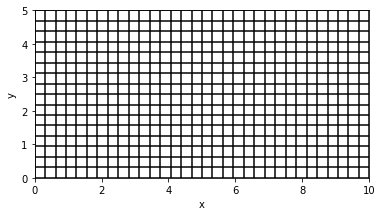

In [2]:
# Define the geometry of the system.
# We use a regular grid (rectangle) with a specified width (x-direction) and height (y-direction).

width = 10   ## BLANK ##
height = 5   ## BLANK ##
resolution = (2**5)/10

# pde.CartesianGrid() creates a grid object (mesh) specified by the rectangle corners and a sampling resolution for both axes.
grid = pde.CartesianGrid(
    [[0, width], [0, height]],
    [int(resolution*i) for i in [width, height]]
)
grid.plot();

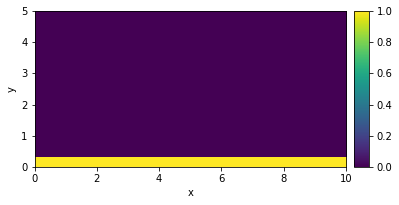

In [3]:
# Define a mask on the grid that represents the 1D membrane.
# Here, we choose the bottom row (y=0) to be the membrane.
# Note: in general, such masks are boolean arrays. For computation purposes, it is often convenient
# to store them as float arrays, though, since some operations (e.g. arithmetic '-') are not well-
# defined on boolean arrays

membrane_mask = pde.ScalarField(grid, dtype=float)
membrane_mask.data[:, 0] = 1.0
membrane_mask.plot();

Any system with two different domains coupled to each other (in this case: cytosol and membrane) comes with certain numerical subtleties, in particular when the domains have different dimensions. One of these subtleties is the diffusion operator (second spatial derivative, laplacian), which looks fundamentally different on flat regions (e.g., a 2D cytosol) vs. curved regions (e.g., a membrane that is not perfectly flat). Here, we have a flat membrane, which saves us a lot of trouble, but nevertheless, we need to make sure that diffusion is restricted exclusively to the membrane for $c_m(x,t)$. To this end, we need to tinker a custom laplacian:

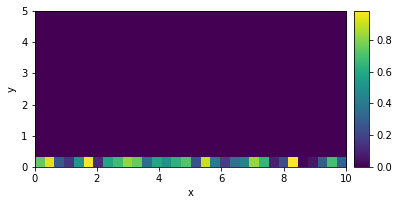

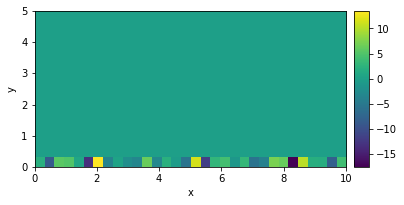

In [4]:
# Set up laplace operator in x direction only
# (You do not need to understand the details here)
make_laplace_x = functools.partial(_make_derivative2, axis=0)
pde.CartesianGrid.register_operator('laplace_x', make_laplace_x)

# Now we test whether the custom laplacian works as intended:
# We set up a random initial field on the membrane, and perform one time step.
# If we did everything right, then there will be no diffusion in y-direction,
# so that the field values at y>0 will remain 0.

# Make a random initial field
c_m = pde.ScalarField.random_uniform(grid)
# Apply the mask to ensure that the field is non-zero only on the membrane
c_m *= membrane_mask
# Look at the field
c_m.plot();
# Perform a time step and look at the field again
c_m._apply_operator('laplace_x', bc='natural').plot();

Now that the numerical details are settled (geometry, mesh, and operators), we can feed the PDEs into the numerical PDE solver. Of course, we have to set values for all parameters first, since the numerical solver can not perform symbolic operations.

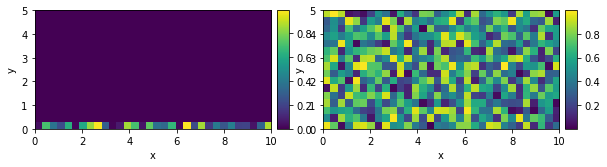

100%|████████████████████████████████████████████████████████████████████████████| 100.0/100.0 [00:23<00:00,  4.29it/s]


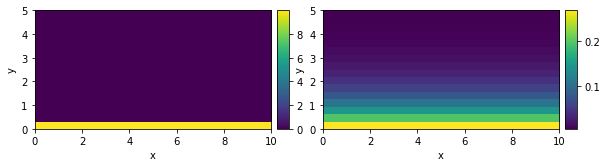

In [5]:
# Define parameters
k_prod = 1. # production in membrane
k = 0.1     # detachment rate
k_degr = 1. # degradation in the cytosol

D_c = 1.    # diffusion in the cytosol
D_m = 0.1   # diffusion on the membrane

# Define the PDEs: l.h.s. specifies the field for which the equation holds,
# r.h.s. equals the time derivative of the field.
# In py-pde, the equations are defined as f-strings.
# The reactions can be restricted to the membrane by multiplying with the
# mask (which will be a field itself and therefore does not need to be escaped).
expr = {'c_m': f'{D_m} * laplace_x(c_m) + mask * ({k_prod} - {k} * c_m)',
        'c_b': f'{D_c} * laplace(c_b) + {k} * mask * c_m - {k_degr} * c_b'}

# Set the initial values for both fields:
c_m = pde.ScalarField.random_uniform(grid) * membrane_mask
c_b = pde.ScalarField.random_uniform(grid)

# Create the PDE object
eq = pde.PDE(expr, consts={'mask': membrane_mask})

# Set the initial values for all fields, and show it
field = pde.FieldCollection([c_m, c_b])
field.plot();

# Simulate the system for 100 time steps, and show the result
res = eq.solve(field, t_range=100, tracker="progress")
res.plot();

### Problem 4: Evaluation
In general, the data you obtain from simulations needs to be post-processed into meaningful quantities. Here, we want to compare the results with the analytical results, i.e., we want to test whether the predicted concentration profile and length scale match the results.

Do so by extracting a meaningful dataset from the solution data (which is stored in ```res.data```), and by plotting your result. Then, use ```numpy```'s ```polyfit``` to fit your predicted concentration profile to the data.
_Hint: ```numpy.polyfit``` only fits polynomials. I your function contains exponentials, fit a polynomial to the log of your data, and then apply the exponential to the fitted result._

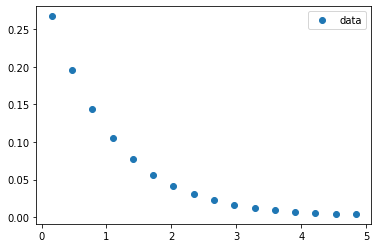

In [13]:
# Get plot data:
coords = grid._axes_coords[1]
concentration = res.data[1,0]

# Plot:
plt.plot(coords, concentration, 'o', label='data')
plt.legend()
plt.show();

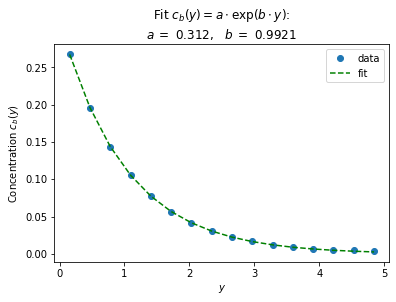

In [16]:
# Guessed function for the concentration depending on the position
def fit_func(x, a, b):
    return a * np.exp(- b * x)

# Fit parameters and covariance for the fit data
popt, pcov = scipy.optimize.curve_fit(fit_func, coords, concentration)

# Visualization
plt.plot(coords, concentration, 'o', label='data')
plt.plot(coords, fit_func(coords, *popt), 'g--',
         label='fit')
plt.title('Fit $c_b(y) = a \cdot \exp(b \cdot y)$:\n'+
         f'$a\;=${popt[0]: .3},\t$b\;=${popt[1]: .4}')
plt.xlabel('$y$')
plt.ylabel('Concentration $c_b(y)$')
plt.legend(loc="upper right")
plt.show()

### Problem 5: Sweeping
A single dataset is of course rarely sufficient to be confident about your predictions. In general, we are mostly interested in the dependence of observable quantities on experimental control parameters. A good way to test whether we got the right _formula_ for the characteristic length scale _\ell_ is to sweep over a few parameters and check whether the results match our formula across the entire sweep range.

Set up the sweep by completing the definition of the method ```simulate_and_fit```. Use this method to obtain a reasonable dataset, and compare it to the function for $\ell$. If you feel like your results take too long to calculate, tinker the mesh parameters (spatial and temporal) to get faster results.

In [30]:
def simulate_and_fit(width=10, height=5, resolution=(2**5)/10,
                    k_prod=1., k=0.1, k_degr=1., D_c=1., D_m=0.1):
    # Make a new grid
    grid = pde.CartesianGrid(
        [[0, width], [0, height]],
        [int(resolution*i) for i in [width, height]]
    )
    
    # Define the membrane mask
    membrane_mask = pde.ScalarField(grid, dtype=float)
    membrane_mask.data[:, 0] = 1.0
    
    # Create the PDE object
    expr = {'c_m': f'{D_m} * laplace_x(c_m) + mask * ({k_prod} - {k} * c_m)',
            'c_b': f'{D_c} * laplace(c_b) + {k} * mask * c_m - {k_degr} * c_b'}
    eq = pde.PDE(expr, consts={'mask': membrane_mask})
    
    # Set initial concentrations
    c_m = pde.ScalarField.random_uniform(grid) * membrane_mask
    c_b = pde.ScalarField.random_uniform(grid)
    
    # Calculate the solution
    field = pde.FieldCollection([c_m, c_b])
    res = eq.solve(field, t_range=10, tracker=[])
    
    # Post-process the data
    coords = grid._axes_coords[1]
    concentration = res.data[1,0]
    popt, pcov = scipy.optimize.curve_fit(fit_func, coords, concentration)
    
    # Return the (relevant) fit parameter
    return popt[1]

In [31]:
# Set the sweep parameters (note: sweep over ~10 values)
sweepParameters = np.power(10, np.arange(-.2, 1.,.25))

# Set up the sweep in a for loop
sweepResults = []
startTime = datetime.datetime.now()
for _ in sweepParameters:
    ETA(list(sweepParameters).index(_), len(sweepParameters), startTime)
    fitResult = simulate_and_fit(D_c=_, width = 2.)
    sweepResults.append(fitResult)

# For convenience, convert the results to a numpy array
sweepResults=np.array(sweepResults)
print('Finished.' + "\t"*100)

Finished.																																																																																																				


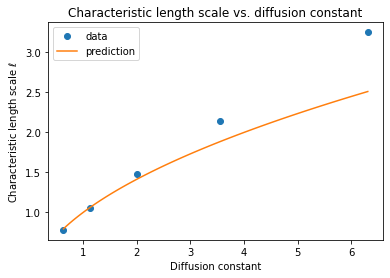

In [33]:
# Define a high-resolution range for plotting the analytic function
aRange = np.linspace(min(sweepParameters), max(sweepParameters), 100)

# Plot the sweep results together with the prediction
plt.plot(sweepParameters, -1/sweepResults, 'o', label='data')
plt.plot(aRange, np.sqrt(aRange/1.), label='prediction')
plt.title("Characteristic length scale vs. diffusion constant")
plt.xlabel('Diffusion constant')
plt.ylabel('Characteristic length scale $\ell$')
plt.legend()
plt.show()

### Problem 6: Interpretation
Despite having done everything correctly, you will notice that the predicted (analytic) dependence of the length scale on the control parameters does not match the sweep for all tested parameters. Why? How could you solve this problem? What does this teach you about numerical simulations in general?

_Hint: Plot one of the profiles where the fit does not match the prediction. What do you notice?_

### Solution 6
Since the geometry is finite, there are boundary effects once the $\ell$ gets close enough to the system size. This problem could be solved easily by increasing the system size. In general, this means that boundary effects as well as other numerical artifacts (such as aliasing, mesh defects etc) need to be taken into account. Also, one should always make sure that the obtained results are not due to one of these numerical effects.